In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load dataset, resample to have balanced classes 

In [13]:
complete_data = pd.read_csv('../resources/data/adult/adult.csv')

rich = complete_data[complete_data['class'] == '>50K']
not_rich = complete_data[complete_data['class'] != '>50K'].sample(len(rich))

data = pd.concat([rich, not_rich])

In [14]:
data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
10,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K
11,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,>50K
19,43,Self-emp-not-inc,292175,Masters,14,Divorced,Exec-managerial,Unmarried,White,Female,0,0,45,United-States,>50K
20,40,Private,193524,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,>50K
25,56,Local-gov,216851,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,>50K
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K


### Train a logistic regression model, using grid search and k-fold cross-validation

In [15]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

def labels_from(df):
    return np.array(df['class'] == '>50K')

train_data, heldout_data = train_test_split(data, test_size=0.2)
test_data, target_data = train_test_split(heldout_data, test_size=0.5)

y_train = labels_from(train_data)
y_test = labels_from(test_data)
y_target = labels_from(target_data)

categorical_columns = ['workclass', 'occupation', 'marital_status', 'education']

numeric_columns = ['hours_per_week', 'age']

feature_transformation = ColumnTransformer(transformers=[
    ('categorical_features', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('scaled_numeric', StandardScaler(), numeric_columns)
])

param_grid = {
    'learner__loss': ['log'],
    'learner__penalty': ['l2', 'l1', 'elasticnet'],
    'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
}

pipeline = Pipeline([
    ('features', feature_transformation), 
    ('learner', SGDClassifier(max_iter=1000))])

search = GridSearchCV(pipeline, param_grid, cv=5)
model = search.fit(train_data, y_train)

In [16]:
score_on_train_data = accuracy_score(y_train, model.predict(train_data))
score_on_noncorrupted_test_data = accuracy_score(y_test, model.predict(test_data))
score_on_noncorrupted_target_data = accuracy_score(y_target, model.predict(target_data))

print("score on train data: ", score_on_train_data)
print("score on test data: ", score_on_noncorrupted_test_data)
print("score on target data: ", score_on_noncorrupted_target_data)

score on train data:  0.8042247907532881
score on test data:  0.8022959183673469
score on target data:  0.8094327597195666


### Introduce errors (missing values) into unseen test data, record resulting class probability entropies and accuracy score as inputs for the meta regressor

In [17]:
def percentiles_of_probas(predictions):
    probs_class_a = np.transpose(predictions)[0]
    probs_class_b = np.transpose(predictions)[1]
    features_a = np.percentile(probs_class_a, np.arange(0,101,5))
    features_b = np.percentile(probs_class_b, np.arange(0,101,5))  
    return np.concatenate((features_a, features_b), axis=0) 

num_features = 42

In [18]:
import random
from scipy.stats import entropy
from tqdm import tqdm

def delete_cells(df, fraction, columns):
    # we operate on a copy of the data
    corrupted_df = df.copy(deep=True)
    
    row_indexes = [row for row in range(corrupted_df.shape[0])]
    # pick random examples
    num_rows_to_pick = int(round(fraction * len(row_indexes)))
    for random_row_index in random.sample(row_indexes, num_rows_to_pick):           
        # delete all specified values in the target columns
        for column in columns:
            column_index = df.columns.get_loc(column)
            corrupted_df.iat[random_row_index, column_index] = 'n/a'
    
    return corrupted_df

generated_training_data = []

for num_columns_affected in tqdm(range(1, 5)):
    for fraction_of_values_to_delete in [0.0, 0.05, 0.25, 0.5, 0.75, 0.99]:    
        for _ in range(0, 100):        
            columns_affected = np.random.choice(categorical_columns, num_columns_affected)        

            corrupted_test_data = delete_cells(test_data, fraction_of_values_to_delete, columns_affected)

            predictions = model.predict_proba(corrupted_test_data)                     
            features = percentiles_of_probas(predictions)
                                       
            score_on_corrupted_test_data = accuracy_score(y_test, model.predict(corrupted_test_data))                
                
            example = np.concatenate((features, [score_on_corrupted_test_data]), axis=0)                                       
            
            generated_training_data.append(example)

100%|██████████| 4/4 [00:48<00:00, 12.19s/it]


### Fit a regression model to the generated training data

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

X = np.array(generated_training_data)[:,:num_features]
y = np.array(generated_training_data)[:,num_features]

param_grid = {
    'learner__n_estimators': np.arange(5,20,5),
    'learner__criterion': ['mae']
}

meta_regressor_pipeline = Pipeline([
    ('scaling', StandardScaler()), 
    ('learner', RandomForestRegressor())
])

meta_regressor = GridSearchCV(meta_regressor_pipeline, param_grid, scoring='neg_mean_absolute_error').fit(X, y)

### Evaluate regression model in predicting effects of errors in the unseen target data

In [29]:
predicted_scores = []
true_scores = []

for num_columns_affected in tqdm(range(1, 5)):
    for fraction_of_values_to_delete in [0.05, 0.25, 0.5, 0.75, 0.99]:    
        for _ in range(0, 100):        
            columns_affected = np.random.choice(categorical_columns, num_columns_affected)        

            corrupted_target_data = delete_cells(target_data, fraction_of_values_to_delete, columns_affected)

            predictions = model.predict_proba(corrupted_target_data)
            features = percentiles_of_probas(predictions)                

            score_on_corrupted_target_data = accuracy_score(y_target, model.predict(corrupted_target_data))
            predicted_score_on_corrupted_target_data = meta_regressor.predict([features])
            
            predicted_scores.append(predicted_score_on_corrupted_target_data)
            true_scores.append(score_on_corrupted_target_data)

100%|██████████| 4/4 [00:46<00:00, 11.64s/it]


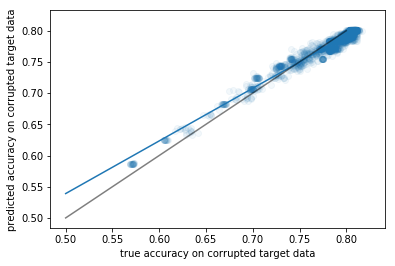

In [30]:
from scipy import stats

gradient, intercept, _, _, _ = stats.linregress(np.array(true_scores).flatten(), np.array(predicted_scores).flatten())

plt.scatter(true_scores, predicted_scores, alpha=0.05)

x1 = np.linspace(0.5, 0.8, 100)
plt.plot(x1, gradient * x1 + intercept, '-')

plt.xlabel("true accuracy on corrupted target data")
plt.ylabel("predicted accuracy on corrupted target data")
plt.plot([0.5, 0.8], [0.5, 0.8], color='black', alpha=0.5)
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true_scores, predicted_scores)
mae = mean_absolute_error(true_scores, predicted_scores)

print("MSE:", mse, ", MAE:", mae)

MSE: 0.00011505457165145492 , MAE: 0.009047942152482424
